In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import Lasso

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [7]:
df = pd.read_csv("Train.csv")
df.head()

,session_id,session_number,client_agent,device_details,date,purchased,added_in_cart,checked_out,time_spent
0,57f879e70d3c5fc2a98102d64c9fd84e,715,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,Desktop - Chrome,2020-01-22,1,0,0,236.886
1,a5442b0c7c33d0a811e7661e556b2de8,55,Product/8.0 iPhone/8.1.3,iPhone - iOS,2020-02-27,1,0,0,1277.455
2,305cb1486ed8610c00b37007926cb2c4,11,Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like ...,iPhone - MobileWeb,2019-08-01,0,0,0,21.704
3,f2c1ecc9993f0071df91ba178450498c,2794,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,Desktop - IE,2019-12-30,0,1,0,455.201
4,e460830ae295e55d2216ebdc761ab9a6,3674,Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_1 like ...,iPhone - Web,2019-09-10,0,0,0,1164.877


In [4]:
df.shape

(5429, 9)

In [3]:
df.dtypes

session_id         object
session_number      int64
client_agent       object
device_details     object
date               object
purchased           int64
added_in_cart       int64
checked_out         int64
time_spent        float64
dtype: object

In [8]:
print("before:", df.shape)
percentile_99 = np.percentile(df.time_spent, 99)
df = df[df.time_spent < percentile_99]
print("after:", df.shape)

before: (5429, 9)
after: (5374, 9)


(array([4287.,  523.,  261.,  116.,   72.,   38.,   36.,   18.,   15.,
           8.]),
 array([  14.4   ,  789.8207, 1565.2414, 2340.6621, 3116.0828, 3891.5035,
        4666.9242, 5442.3449, 6217.7656, 6993.1863, 7768.607 ]),
 <a list of 10 Patch objects>)

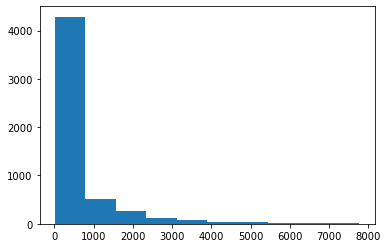

In [9]:
plt.hist(df['time_spent'])

(array([1730.,  529.,  434.,  435.,  463.,  520.,  490.,  439.,  234.,
         100.]),
 array([2.66722821, 3.29629   , 3.92535179, 4.55441359, 5.18347538,
        5.81253718, 6.44159897, 7.07066077, 7.69972256, 8.32878435,
        8.95784615]),
 <a list of 10 Patch objects>)

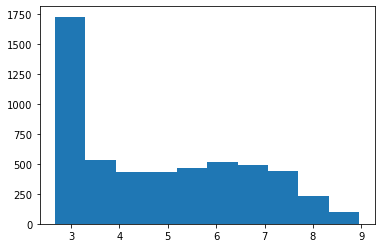

In [10]:
### Taking log of the target variable makes more sense
plt.hist(np.log(df['time_spent']))

In [5]:
df.time_spent = np.log(df.time_spent)

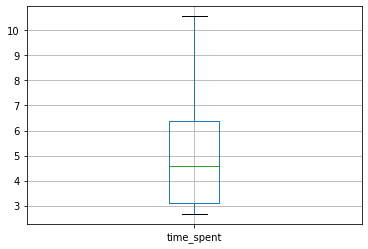

In [6]:
df.boxplot(column=['time_spent'])

In [7]:
df.describe()

,session_number,purchased,added_in_cart,checked_out,time_spent
count,5429.000000,5429.000000,5429.000000,5429.000000,5429.000000
mean,1072.835329,0.159145,0.162092,0.017499,4.908498
std,1436.351474,0.365845,0.368570,0.131132,1.782779
min,11.000000,0.000000,0.000000,0.000000,2.667228
25%,121.000000,0.000000,0.000000,0.000000,3.122321
50%,517.000000,0.000000,0.000000,0.000000,4.588146
75%,1397.000000,0.000000,0.000000,0.000000,6.397701
max,7722.000000,1.000000,1.000000,1.000000,10.558258


In [9]:
df.drop(columns=['session_id', 'session_number','client_agent'], inplace=True)
df = pd.concat([df, pd.get_dummies(df['device_details'])], axis=1)
df.drop(columns = 'device_details', inplace=True)

In [10]:
df.head()

,date,purchased,added_in_cart,checked_out,time_spent,Android Phone - Android,Android Phone - MobileWeb,Android Phone - Web,Android Tablet - Android,Android Tablet - MobileWeb,...,Desktop - Firefox,Desktop - IE,Desktop - Safari,Other - Other,Unknown - MobileWeb,iPad - Web,iPad - iOS,iPhone - MobileWeb,iPhone - Web,iPhone - iOS
0,2020-01-22,1,0,0,5.467579,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2020-02-27,1,0,0,7.152625,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,2019-08-01,0,0,0,3.077497,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2019-12-30,0,1,0,6.120739,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,2019-09-10,0,0,0,7.060371,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [11]:
df['date'] = pd.to_datetime(df['date'])
df['week_of_year'] = df['date'].dt.week
df['day_of_month'] = df['date'].apply(lambda x: str(x).split('-')[-1].split(' ')[0])
df['day_of_month'] = df['day_of_month'].apply(lambda x: int(x))
df['month_of_year'] = df['date'].dt.month
df['day_of_week'] = df['date'].dt.dayofweek

df['week_end'] = 0
df.loc[df['day_of_week'].isin([0,6]), 'week_end'] = 1

df['month_end'] = 0
df.loc[df['day_of_month'].isin([28,29,30,31,1,2]), 'month_end'] = 1

df['year_end'] = 0
df.loc[df['week_of_year'].isin([51,52,1,2]), 'year_end'] = 1

df.drop(columns = ['date'], inplace=True)
df.head()

,purchased,added_in_cart,checked_out,time_spent,Android Phone - Android,Android Phone - MobileWeb,Android Phone - Web,Android Tablet - Android,Android Tablet - MobileWeb,Android Tablet - Web,...,iPhone - MobileWeb,iPhone - Web,iPhone - iOS,week_of_year,day_of_month,month_of_year,day_of_week,week_end,month_end,year_end
0,1,0,0,5.467579,0,0,0,0,0,0,...,0,0,0,4,22,1,2,0,0,0
1,1,0,0,7.152625,0,0,0,0,0,0,...,0,0,1,9,27,2,3,0,0,0
2,0,0,0,3.077497,0,0,0,0,0,0,...,1,0,0,31,1,8,3,0,1,0
3,0,1,0,6.120739,0,0,0,0,0,0,...,0,0,0,1,30,12,0,1,1,1
4,0,0,0,7.060371,0,0,0,0,0,0,...,0,1,0,37,10,9,1,0,0,0


In [12]:
def eval_score(y_pred, y_true):
    error = np.sqrt(mean_squared_log_error(y_true, y_pred))
    return error

In [13]:
X = df[[k for k in df.columns if k != 'time_spent']]
y = df['time_spent']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 4)

reg_ls = Lasso(random_state=4).fit(X_train, y_train)
y_train_pred = reg_ls.predict(X_train)
y_test_pred = reg_ls.predict(X_test)

In [16]:
eval_score(np.exp(y_train_pred), np.exp(y_train)), eval_score(np.exp(y_test_pred), np.exp(y_test))

(1.7599697764732627, 1.7667829121573448)

In [17]:
df_prod = pd.read_csv('Test.csv')
df_prod.head()

,session_id,session_number,client_agent,device_details,date,purchased,added_in_cart,checked_out
0,0bf72b05b2cf70dc5e28c3c09f9c4f97,99,Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7....,Desktop - IE,2020-01-07,1,0,0
1,6bc696d99954e4f1367e845465186aef,935,Product/160393 Android/4.3 Device/samsung_GT-I...,Android Phone - Android,2020-02-13,0,0,0
2,3d8611a5ea0f621d205b67f09f663a89,902,Product/4.2.2 iPhone/7.1.2,iPhone - iOS,2019-10-14,1,0,0
3,a0351545c032fd0da36289410c6c3354,3223,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,Desktop - IE,2020-01-26,0,0,0
4,dd8999772b0ab27225fb05e5df2f1da6,231,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,Desktop - Chrome,2020-01-29,0,0,0


In [18]:
df_prod.drop(columns=['session_id', 'session_number','client_agent'], inplace=True)
df_prod = pd.concat([df_prod, pd.get_dummies(df_prod['device_details'])], axis=1)
df_prod.drop(columns = 'device_details', inplace=True)

df_prod['date'] = pd.to_datetime(df_prod['date'])

df_prod['week_of_year'] = df_prod['date'].dt.week
df_prod['day_of_month'] = df_prod['date'].apply(lambda x: str(x).split('-')[-1].split(' ')[0])
df_prod['day_of_month'] = df_prod['day_of_month'].apply(lambda x: int(x))

df_prod['month_of_year'] = df_prod['date'].dt.month
df_prod['day_of_week'] = df_prod['date'].dt.dayofweek

df_prod['week_end'] = 0
df_prod.loc[df_prod['day_of_week'].isin([0,6]), 'week_end'] = 1

df_prod['month_end'] = 0
df_prod.loc[df_prod['day_of_month'].isin([28,29,30,31,1,2]), 'month_end'] = 1

df_prod['year_end'] = 0
df_prod.loc[df_prod['week_of_year'].isin([51,52,1,2]), 'year_end'] = 1

df_prod.drop(columns = ['date'], inplace=True)

X_prod = df_prod.copy()
X_prod['Android Tablet - MobileWeb'] = 0

X_prod = X_prod[list(X.columns)]
X_prod

,purchased,added_in_cart,checked_out,Android Phone - Android,Android Phone - MobileWeb,Android Phone - Web,Android Tablet - Android,Android Tablet - MobileWeb,Android Tablet - Web,Desktop - Chrome,...,iPhone - MobileWeb,iPhone - Web,iPhone - iOS,week_of_year,day_of_month,month_of_year,day_of_week,week_end,month_end,year_end
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,2,7,1,1,0,0,1
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,7,13,2,3,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,1,42,14,10,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,4,26,1,6,1,0,0
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,5,29,1,2,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2322,0,0,0,0,0,0,0,0,0,0,...,0,0,0,45,6,11,2,0,0,0
2323,0,1,0,0,0,0,0,0,0,1,...,0,0,0,3,18,1,5,0,0,0
2324,0,0,0,0,0,0,0,0,0,0,...,0,0,1,3,14,1,1,0,0,0
2325,1,0,0,0,0,0,0,0,0,0,...,0,0,0,40,1,10,1,0,1,0


In [19]:
reg_ls_all = Lasso(random_state=4).fit(X, y)

In [20]:
y_prod_pred = np.exp(reg_ls.predict(X_prod))
y_prod_pred

array([154.63105508, 151.30220604, 129.9227031 , ..., 153.95947709,
       131.05863225, 150.64508557])

In [21]:
y_prod_pred = np.exp(reg_ls_all.predict(X_prod))
y_prod_pred

array([146.60220063, 144.54219156, 130.91025091, ..., 146.18786337,
       131.653375  , 144.13367643])

In [22]:
df_sample = pd.read_csv("Sample Submission.csv")
df_sample.head()

,time_spent
0,0
1,0
2,0
3,0
4,0


In [23]:
df_sample['time_spent'] = np.exp(reg_ls_all.predict(X_prod))

In [24]:
df_sample

,time_spent
0,146.602201
1,144.542192
2,130.910251
3,145.774697
4,145.362699
...,...
2322,129.803422
2323,146.187863
2324,146.187863
2325,131.653375
